# Target units and Capacity

In [1]:
# append path to find utils module in urbansim
import os 
import sys
cwd = os.getcwd() 
parentdir =  os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(parentdir) # to get path to utils module

In [2]:
from sqlalchemy import create_engine
from pysandag.database import get_connection_string
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# connect to database and get version ids
db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)
versions = utils.yaml_to_dict('../data/scenario_config.yaml', 'scenario')

##### from urbansim.parcel

In [4]:
parcel_capacity_sql = '''
    SELECT [parcel_id],[jurisdiction_id],[cap_jurisdiction_id],[site_id],
           [du_2015],[du_2017],[capacity_1],[capacity_2]
      FROM [urbansim].[urbansim].[parcel]'''
capacity_df = pd.read_sql(parcel_capacity_sql,mssql_engine)
urbansim_parcel_capacity = int(capacity_df.loc[capacity_df.site_id.isnull()].capacity_2.sum())
print("\nCapacity from urbansim.parcel where site id is null: {:,}".format(urbansim_parcel_capacity))
# 291,989


Capacity from urbansim.parcel where site id is null: 291,989


##### from urbansim.additional_capacity

In [5]:
assigned_parcel_sql = '''
SELECT  a.parcel_id, cap_jurisdiction_id, jurisdiction_id, a.du, a.type
   FROM [urbansim].[urbansim].[additional_capacity] a
   JOIN urbansim.parcel p on p.parcel_id = a.parcel_id
  WHERE version_id = %s'''
assigned_parcel_sql = assigned_parcel_sql % versions['additional_capacity_version']
assigned_df = pd.read_sql(assigned_parcel_sql, mssql_engine)
assigned_capacity = int(assigned_df.du.sum())
print("\nCapacity from urbansim.additional_capacity (ADU and SGOAs): {:,}".format(assigned_capacity))
assigned_df.type.unique()
sgoa_assigned = assigned_df.loc[assigned_df.type.isin(['mc', 'tco', 'uc', 'tc','cc'])]
adu_assigned  = assigned_df.loc[assigned_df.type=='adu']
sgoa_assigned_capacity = int(sgoa_assigned.du.sum())
adu_assigned_capacity = int(adu_assigned.du.sum())
print("\n      Capacity from sgoa: {:,}".format(sgoa_assigned_capacity))
print("\n      Capacity from adu: {:,}".format(adu_assigned_capacity))
# adus in city of san diego, chula vista, oceanside, el cajon
starting_2019_adu = assigned_df.loc[(assigned_df.cap_jurisdiction_id.isin([14,2,12,5])) &\
                                    (assigned_df.type=='adu')]
adu_2019_assigned_capacity = int(starting_2019_adu.du.sum())
print("\n                 note: 2019 to 2035 adu: {:,} \
(city of san diego, chula vista, oceanside, el cajon)".format(adu_2019_assigned_capacity))
# 5316
# 136,158
# 138,035
# 163,035


Capacity from urbansim.additional_capacity (ADU and SGOAs): 163,035

      Capacity from sgoa: 149,725

      Capacity from adu: 13,310

                 note: 2019 to 2035 adu: 5,316 (city of san diego, chula vista, oceanside, el cajon)


##### "urbansim.scheduled_development_parcel" & "urbansim.urbansim.scheduled_development_do_not_use"

In [6]:
sched_dev_parcel_sql = '''
SELECT [capacity_3] FROM [urbansim].[urbansim].[scheduled_development_parcel]'''
sched_dev_df = pd.read_sql(sched_dev_parcel_sql, mssql_engine)
sched_dev_capacity = int(sched_dev_df.capacity_3.sum())
print("\nScheduled development capacity from urbansim.scheduled_development_parcel : {:,}".\
      format(sched_dev_capacity))
sched_dev_do_not_use_sql = '''
SELECT [sched_version_id],s.[parcel_id],p.cap_jurisdiction_id,[yr],s.[site_id],[capacity_3]
  FROM [urbansim].[urbansim].[scheduled_development_do_not_use] s
  JOIN urbansim.urbansim.parcel p ON p.parcel_id = s.parcel_id
  WHERE sched_version_id = %s'''
sched_dev_do_not_use_sql = sched_dev_do_not_use_sql % versions['sched_dev_version']
site_do_not_use = pd.read_sql(sched_dev_do_not_use_sql,mssql_engine)
sched_dev_capacity_do_not_use = int(site_do_not_use.capacity_3.sum())
print("\nScheduled developments from scheduled_development_do_not_use: {:,}".format(sched_dev_capacity_do_not_use))
# 78,976


Scheduled development capacity from urbansim.scheduled_development_parcel : 78,976

Scheduled developments from scheduled_development_do_not_use: 78,976


##### urbansim.urbansim_target_housing_units

In [7]:
units_needed_sql = '''
SELECT [yr], [version_id], [housing_units_add]
  FROM [urbansim].[urbansim].[urbansim_target_housing_units]
  WHERE version_id = %s'''
units_needed_sql = units_needed_sql % versions['demographic_simulation_id']
units_needed_df =  pd.read_sql(units_needed_sql, mssql_engine)
units_needed_df['total_housing_units_add'] = units_needed_df['housing_units_add'].cumsum()
units_needed = int(sum(units_needed_df.housing_units_add))
print("\n  Target units to add : {:,}\n\
      (from urbansim.urbansim_target_housing_units version id {:})".\
      format(units_needed,versions['demographic_simulation_id']))
# 468,866
# 534,000


  Target units to add : 534,000
      (from urbansim.urbansim_target_housing_units version id 106)


## Total Capacity

In [8]:
dme_capacity_sql = '''select sum(a.cap) as RC from  
(select x.parcel_id,coalesce(y.capacity_3,x.capacity_2) as cap 
from  [urbansim].[urbansim].[parcel] as x 
left join [urbansim].[urbansim].[scheduled_development_parcel] as  y 
on x.parcel_id=y.parcel_id) as a'''
dme_capacity_df = pd.read_sql(dme_capacity_sql,mssql_engine)
dme_capacity_calc = int(dme_capacity_df.RC[0])
total_capacity = urbansim_parcel_capacity + assigned_capacity + sched_dev_capacity
print("\n\nTotal Capacity: {:,}\n".format(total_capacity))
print("       = {:,} (urbansim.parcel) + {:,} (sched dev) + {:,} (assigned capacity) \n".\
      format(urbansim_parcel_capacity,sched_dev_capacity,assigned_capacity))
print("            ({:,} urbansim.parcel and sched dev only)\n".format(urbansim_parcel_capacity+sched_dev_capacity))
#print("            ({:,} DME calculation for urbansim.parcel and sched dev only using COALESCE(capacity_3,capacity_2))\n".\
#      format(dme_capacity_calc))
remaining_capacity = total_capacity - units_needed
print("\n Remaining capacity 2050: {:,}\n       = {:,} capacity - {:,} units needed\n".\
format(remaining_capacity,total_capacity,units_needed))
# 507,123
# 509,000



Total Capacity: 534,000

       = 291,989 (urbansim.parcel) + 78,976 (sched dev) + 163,035 (assigned capacity) 

            (370,965 urbansim.parcel and sched dev only)


 Remaining capacity 2050: 0
       = 534,000 capacity - 534,000 units needed



In [9]:
# compare to 364,374 capacity previously

# Output of simulation 

##### from urbansim.urbansim_lite_output

In [10]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\nRun id : {:,}".format(run_id))

hs_change_sql = '''
    SELECT o.parcel_id, j.name,  p.cap_jurisdiction_id, p.jurisdiction_id, p.mgra_id, p.luz_id,
    unit_change as hs_change, source, capacity_type,year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
      JOIN urbansim.urbansim.parcel p on p.parcel_id = o.parcel_id
      JOIN urbansim.ref.jurisdiction j on p.cap_jurisdiction_id = j.jurisdiction_id
     WHERE run_id =  %s
  ORDER BY j.name,p.jurisdiction_id, year_simulation'''
hs_change_sql = hs_change_sql % run_id
hs = pd.read_sql(hs_change_sql,mssql_engine)
units_added = int(hs.hs_change.sum())
units_from_sched_dev = int(hs.loc[hs.capacity_type=='sch'].hs_change.sum())
sched_dev_difference = int(sched_dev_capacity_do_not_use - units_from_sched_dev)
units_from_assigned = int(hs.loc[~hs.capacity_type.isin(['sch','jur'])].hs_change.sum())
assigned_difference = int(assigned_capacity - units_from_assigned)
units_from_urbansim_parcel = int(hs.loc[hs.capacity_type=='jur'].hs_change.sum())
urbansim_parcel_difference = int(urbansim_parcel_capacity - units_from_urbansim_parcel)

print("\nUnits added: {:,} (from capacity {:,})".\
      format(units_added,total_capacity))
print("\n    (Target: {:,})".format(units_needed))
print("\n       Urb parcel units: {:,} (capacity {:,}) (remaining {:,})".\
      format(units_from_urbansim_parcel,urbansim_parcel_capacity,urbansim_parcel_difference))
print("\n       Sched dev units: {:,} (capacity {:,}) (remaining {:,})".\
      format(units_from_sched_dev,sched_dev_capacity_do_not_use,sched_dev_difference))
print("\n       Additional units: {:,} (capacity {:,}) (remaining {:,})".\
      format(units_from_assigned,int(assigned_df.du.sum()),assigned_difference))
print("\n Total Remaining Capacity : {:,}".format(remaining_capacity))
# remaining 38,257


Run id : 38

Units added: 534,000 (from capacity 534,000)

    (Target: 534,000)

       Urb parcel units: 291,989 (capacity 291,989) (remaining 0)

       Sched dev units: 78,976 (capacity 78,976) (remaining 0)

       Additional units: 163,035 (capacity 163,035) (remaining 0)

 Total Remaining Capacity : 0


## Housing Units by Capacity Type Plot

In [55]:
hs2 = hs.copy()
hs2.replace('cc', 'sgoa',inplace=True)
hs2.replace('mc', 'sgoa',inplace=True)
hs2.replace('tc', 'sgoa',inplace=True)
hs2.replace('tco', 'sgoa',inplace=True)
hs2.replace('uc', 'sgoa',inplace=True)
units_added_by_capacity_type_and_yr = pd.DataFrame({'units_by_type': hs2.
                                          groupby(["year_simulation","capacity_type"])
                                          .hs_change.sum()}).reset_index()
type_pivot = units_added_by_capacity_type_and_yr.pivot\
(index='year_simulation', columns='capacity_type', values='units_by_type').\
reset_index().rename_axis(None, axis=1)
type_pivot.fillna(0,inplace=True)

In [56]:
type_pivot.set_index('year_simulation',inplace=True)
cols = ['sch','jur','sgoa','adu']
type_pivot = type_pivot[cols]
type_pivot[cols] = type_pivot[cols].applymap(np.int32)

In [57]:
# type_pivot = type_pivot.loc[type_pivot.index.isin(list(range(2017,2023)))]

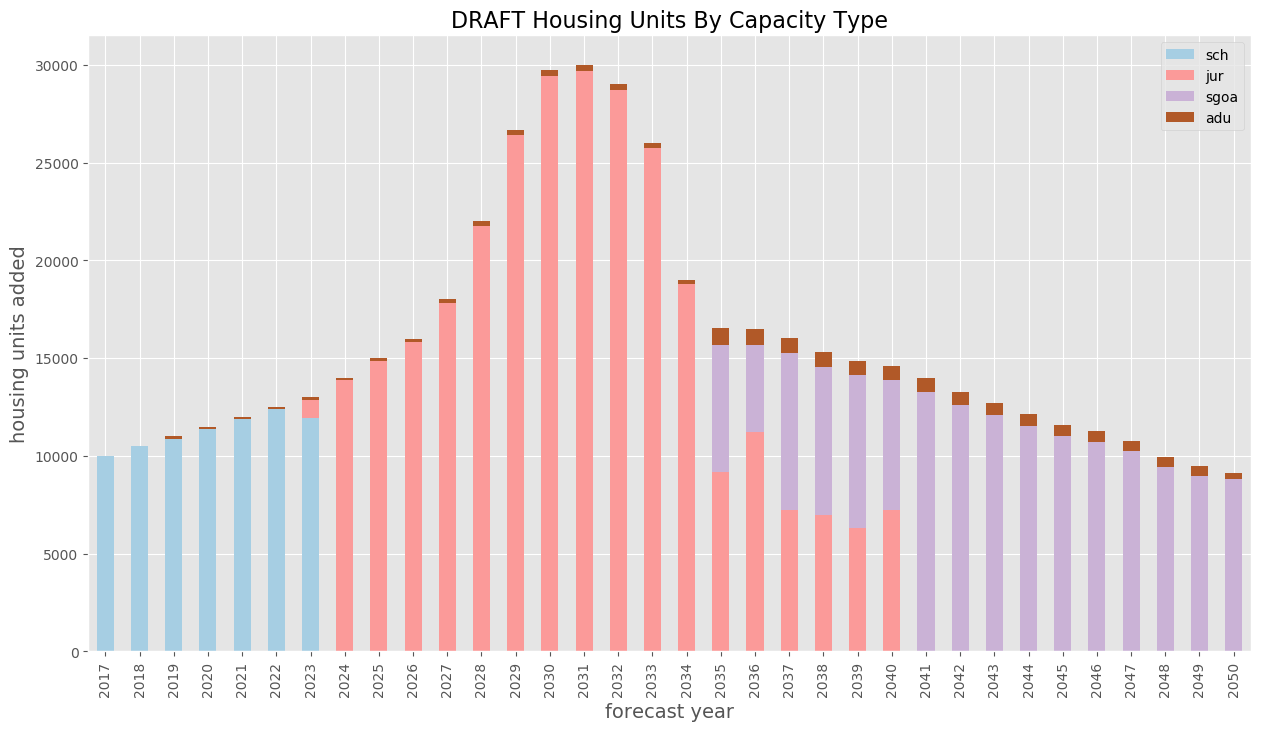

In [73]:
# NOTE: the width and fig size are important to show adu. 
# if fig size and width are too small the bar is no longer visible.
# see https://stackoverflow.com/questions/47740478/matplotlib-bar-chart-some-bars-are-not-visible-and-seem-to-be-of-different-width

plt.style.use('ggplot')
#plt.style.use('default')
ax = type_pivot.plot(kind='bar',stacked=True,width=0.5,colormap = 'Paired', #colormap='coolwarm',\
                     figsize=(15, 8)) #(stacked=True,colormap='Paired')
ax.set_ylabel("housing units added",size=14)
ax.set_xlabel("forecast year",size=14)
ax.set_title('DRAFT Housing Units By Capacity Type',size=16)
plt.show()
fig = ax.get_figure()
fig.savefig('out/test.png')

In [28]:
# type_pivot

###  Additional Dwelling Units Percentage of Total Units

In [ ]:
type_pivot['total_units'] = type_pivot.sum(axis=1)
type_pivot['adu_share'] = type_pivot.adu / type_pivot.total_units
type_pivot[['sch','jur','adu','SGOA','total_units']] =type_pivot[['sch','jur','adu','SGOA','total_units']].astype(int)
type_pivot['adu_share'] = type_pivot.adu_share.round(3)
type_pivot

# Output of simulation

##### from urbansim.urbansim_lite_output

In [ ]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\n   Max run id : {:,}".format(run_id))

hs_change_sql = '''
    SELECT o.parcel_id, sum(unit_change) as hs_change
      FROM urbansim.urbansim.urbansim_lite_output o 
     WHERE run_id =  %s 
     GROUP BY parcel_id'''
hs_change_sql = hs_change_sql % run_id
hs_change = pd.read_sql(hs_change_sql,mssql_engine)
print("\n   Units added: {:,}".format(int(hs_change.hs_change.sum())))


##### from urbansim.sr14_residential_cap_parcel_results

In [ ]:
cap_unit_output_sql = '''SELECT scenario_id, sum([tot_chg_hs]) as units_built
  FROM [urbansim].[urbansim].[sr14_residential_cap_parcel_results]
  group by scenario_id
'''
cap_unit_output_df = pd.read_sql(cap_unit_output_sql, mssql_engine)
# Can manually set scenario_id here:
# max_scenario = 
max_scenario = int(max(cap_unit_output_df.scenario_id.values))
units_built = int(cap_unit_output_df.loc[cap_unit_output_df.\
                scenario_id==max_scenario].units_built.values)
print("\nCapacity Built in scenario {:,}: {:,}".\
      format(max_scenario, units_built))
print("\nDifference remaining: {:,}\n       {:,} units needed - {:,} units built".\
      format((units_needed - units_built),units_needed,units_built))

#### count of parcels in urbansim.sr14_residential_cap_parcel_results

In [ ]:
cap_unit_output_sql = '''SELECT parcel_id, sum([tot_chg_hs]) as units_built
  FROM [urbansim].[urbansim].[sr14_residential_cap_parcel_results]
  group by parcel_id'''
cap_unit_output_df = pd.read_sql(cap_unit_output_sql, mssql_engine)
len(cap_unit_output_df)

#### count of "parcels + capacity_type" from input db

###### i.e. parcels are repeated with different capacity types

In [ ]:
urb_parcel_cap = capacity_df.loc[(capacity_df.capacity_2>0) & (capacity_df.site_id.isnull())]
urb_parcel_cap = urb_parcel_cap[['parcel_id','capacity_2']].copy()
urb_parcel_cap.rename(columns={"capacity_2": "capacity_jur"}, inplace=True)

add_df = assigned_df[['parcel_id','du']].copy()
add_df.rename(columns={"du": "capacity_assigned"}, inplace=True)

sched = site_do_not_use[['parcel_id','capacity_3']].copy()
sched.rename(columns={"capacity_3": "capacity_sch"}, inplace=True)

# print(len(urb_parcel_cap))
# print(len(sched))
# print(len(add_df))
print(len(urb_parcel_cap) + len(sched) + len(add_df))

#### get total capacity for each parcel from jur and sch and additional 

In [ ]:
cap_df = capacity_df[['parcel_id','cap_jurisdiction_id']].copy()
cap_df = pd.merge(cap_df,urb_parcel_cap,how='left',on='parcel_id')
cap_df = pd.merge(cap_df,add_df,how='left',on='parcel_id')
cap_df = pd.merge(cap_df,sched,how='left',on='parcel_id')
cap_df.fillna(0,inplace=True)
cap_df['capacity'] = cap_df['capacity_jur'] + cap_df['capacity_assigned'] + cap_df['capacity_sch']
cap = cap_df.loc[cap_df.capacity>0].copy()
# print(len(capacity_df))
# print(len(cap_df))
# print(len(cap))

#### merge input capacity with output from urbansim.sr14_residential_cap_parcel_results

In [ ]:
compare_cap_w_units_built = pd.merge(cap_unit_output_df,cap,on='parcel_id')
compare_cap_w_units_built['remaining_cap'] = compare_cap_w_units_built['capacity'] - compare_cap_w_units_built['units_built']

#### parcels with remaining capacity and remaining cap is not equal to assigned capacity

In [ ]:
compare_cap_w_units_built[(compare_cap_w_units_built.remaining_cap!=0) & \
                          (compare_cap_w_units_built.capacity_jur>0) & \
                        (compare_cap_w_units_built.remaining_cap != compare_cap_w_units_built.capacity_assigned)]

#### parcels with remaining capacity that are sched dev

In [ ]:
print(compare_cap_w_units_built[(compare_cap_w_units_built.remaining_cap!=0) & \
                          (compare_cap_w_units_built.capacity_sch>0)])

#### merge with output from urbansim.urbansim_lite_output

In [ ]:
compare_cap_w_units_built = pd.merge(compare_cap_w_units_built,hs_change,on='parcel_id',how="left")
compare_cap_w_units_built.hs_change.fillna(0,inplace=True)

#### check for discrepancy between urbansim_lite_output and sr14_residential_cap_parcel_results

In [ ]:
compare_cap_w_units_built['discrepancy'] = compare_cap_w_units_built['units_built'] - compare_cap_w_units_built['hs_change']
print(compare_cap_w_units_built.loc[compare_cap_w_units_built.discrepancy!=0])

#### recheck total number of units added

In [ ]:
print(compare_cap_w_units_built.hs_change.sum())
print(compare_cap_w_units_built.units_built.sum())

### Tabulate total number of unique parcels

In [ ]:
provided_capacity_parcel_count_sql = '''Select count(*)
    from urbansim.urbansim.parcel
    where capacity_2 > 0 and site_id is NULL
'''
provided_capacity_parcel_count_df = pd.read_sql(provided_capacity_parcel_count_sql, mssql_engine)
prov_parcels = int(provided_capacity_parcel_count_df.values)

scheduled_dev_parcel_count_sql = '''select count(*) 
    from urbansim.urbansim.scheduled_development_do_not_use 
    where sched_version_id = %s and
    capacity_3 > 0 and parcel_id not in (
        Select parcel_id from urbansim.urbansim.parcel 
        where capacity_2 > 0 and site_id is NULL)
'''
scheduled_dev_parcel_count_sql = scheduled_dev_parcel_count_sql % versions['sched_dev_version']
scheduled_dev_parcel_count_df = pd.read_sql(scheduled_dev_parcel_count_sql, mssql_engine)
sched_dev_parcels = int(scheduled_dev_parcel_count_df.values)

additional_capacity_parcel_count_sql = '''select count(*) 
    from urbansim.urbansim.additional_capacity
    where version_id = %s and parcel_id not in (
        Select parcel_id from urbansim.urbansim.parcel 
        where capacity_2 > 0 and site_id is NULL)
    and parcel_id not in (
        Select parcel_id from urbansim.urbansim.scheduled_development_do_not_use 
        where capacity_3 > 0)
'''
additional_capacity_parcel_count_sql = additional_capacity_parcel_count_sql % versions['additional_capacity_version']
additional_capacity_parcel_count_df = pd.read_sql(additional_capacity_parcel_count_sql, mssql_engine)
extra_parcels = int(additional_capacity_parcel_count_df.values)

total_parcels = prov_parcels + sched_dev_parcels + extra_parcels

print("\nParcels originally provided by Jurisdictions: {:,}\n   Only when capacity_2 > 0 and site_id is NULL".\
     format(prov_parcels))
print("\nScheduled Development parcel count: {:,}\n   Excludes parcels chosen in step above".\
     format(sched_dev_parcels))
print("\nNew parcels added for additional capacity needs: {:,}\n   Excludes parcels chosen in both steps above".\
     format(extra_parcels))
print("\nTotal unique parcels: {:,}".format(total_parcels))

In [ ]:
total_output_rows_sql = '''Select count(*)
    from urbansim.urbansim.sr14_residential_cap_parcel_results
'''
total_output_rows_df = pd.read_sql(total_output_rows_sql, mssql_engine)
total_output_rows = int(total_output_rows_df.values)
rows_per_year = round(total_output_rows/35, 3)

print("\nTotal Rows in Output: {:,}".format(total_output_rows))
print("\nRows per year with 35 years: {:,}".format(rows_per_year))
print("Difference: {:,}\n       {:,} rows per year - {:,} unique parcels".\
     format(round(rows_per_year-total_parcels, 3), rows_per_year, total_parcels))

#### Find any years where the parcel count is not equal to total uniqe parcels

In [ ]:
output_by_yr_sql = '''Select yr,count(*) as parcel_count
    from urbansim.urbansim.sr14_residential_cap_parcel_results
    GROUP BY yr
    ORDER BY yr
'''
output_by_yr = pd.read_sql(output_by_yr_sql, mssql_engine)
print(output_by_yr.loc[output_by_yr.parcel_count != total_parcels])

#### to debug print duplicated parcels in a given year (where parcel count not equal total parcels)

In [ ]:
output_by_yr_sql = '''
    SELECT *
    FROM urbansim.urbansim.sr14_residential_cap_parcel_results
    WHERE yr=2032'''
output_by_yr = pd.read_sql(output_by_yr_sql, mssql_engine)
duplicated_parcels = output_by_yr.parcel_id.loc[output_by_yr.parcel_id.duplicated()].tolist()
print(output_by_yr.loc[output_by_yr.parcel_id.\
                       isin(duplicated_parcels)]\
      [['parcel_id', 'yr','cap_jurisdiction_id', 'hs', 'tot_cap_hs', 'tot_chg_hs','regional_overflow']])

# Plot of Housing Units Added by Year

In [ ]:
units_added_by_yr = pd.DataFrame({'subregional_simulation': hs.
                                          groupby(["year_simulation"])
                                          .hs_change.sum()}).reset_index()
housing_units_by_yr = pd.merge(units_needed_df[['yr','housing_units_add']],units_added_by_yr,\
                               left_on='yr',right_on='year_simulation')
housing_units_by_yr['housing_units_add'] = housing_units_by_yr['housing_units_add'].astype(int)
housing_units_by_yr.rename(columns={"housing_units_add": "forecast"}, inplace=True)
housing_units_by_yr.drop(['year_simulation'], axis=1,inplace=True)
housing_units_by_yr.set_index('yr',inplace=True)
axes = housing_units_by_yr.plot(style='.-',subplots=True, figsize=(6, 6));
ptitle = 'DRAFT Housing Units By Year \n(version_id=' + \
str(versions['demographic_simulation_id']) + ')'
axes.flat[0].set_title(ptitle,size=16) 
axes[0].set_ylabel('housing units')
axes[1].set_ylabel('housing units')


In [ ]:
housing_units_by_yr.head()

# Housing units 2017 & 2050

In [ ]:
du_2017 = capacity_df.du_2017.sum()
print("\n Housing units 2017 from urbansim.parcel: {:,}\n".format(du_2017))
housing_unit_estimates_sql = '''SELECT  [yr],[du]FROM [isam].[defm].[housing_units]'''
housing_unit_estimates = pd.read_sql(housing_unit_estimates_sql, mssql_engine)
print("\n Housing units 2017 from estimates in defm.housing_units: {:,}\n".\
      format(int(housing_unit_estimates.loc[housing_unit_estimates.yr==2017].du)))
print("\n DIFFERENCE in housing units urbansim and defm.housing_units: {:,}\n".\
      format(int(housing_unit_estimates.loc[housing_unit_estimates.yr==2017].du)\
                - du_2017 ))

print("\n Total Housing units 2050: {:,}\n\n (= {:,} du 2017 +  {:,} units needed) \n".\
      format(du_2017 + units_needed,du_2017,units_needed)) 
# housing units du_2017 from urbansim.parcel
# 1,192,748
# housing units from estimates:
# 2015: 1,183,211
# 2016: 1,194,603
# 2017: 1,205,531
# 2018: 1,217,060

### QC "units to add" not equal "units added"

In [ ]:
hu = housing_units_by_yr.copy()
hu.rename(columns={"forecast":"hu_forecast"}, inplace=True)
hu.rename(columns={"subregional_simulation":"hu_subregional"}, inplace=True)
hu['DIFF'] = hu.hu_subregional - hu.hu_forecast
hu['cum_sum_forecast'] = hu.hu_forecast.cumsum()
hu['cum_sum_subregional'] = hu.hu_subregional.cumsum()
print('\n\nQC: Years that "Units to Add" not equal to "Units Added"')
print(hu.loc[hu.hu_forecast != hu.hu_subregional])

In [ ]:
### QC HS per year

In [ ]:
cap_parcel_table_sql = '''
SELECT [yr] ,sum([hs]) as hs ,sum([tot_cap_hs]) as hs_cap
      ,sum([tot_chg_hs]) as hs_chg
  FROM [urbansim].[urbansim].[sr14_residential_cap_parcel_results]
  WHERE scenario_id = 1
  group by yr
  order by yr'''
cap_parcel_table = pd.read_sql(cap_parcel_table_sql, mssql_engine)
cap_parcel_table['calculated_hs_chg'] = cap_parcel_table.hs.diff()
cap_parcel_table['diff_hs_chg'] = cap_parcel_table.hs_chg - cap_parcel_table.calculated_hs_chg
compare_chg_table = pd.merge(cap_parcel_table, units_needed_df[['yr','housing_units_add']],
                             how='left', on='yr')

compare_chg_table[['yr', 'housing_units_add', 'hs_chg', 'calculated_hs_chg', 'diff_hs_chg']]